In [94]:
import os
import time

from glob import glob
from subprocess import check_output
from datetime import datetime
from pathlib import Path

In [95]:
## PROCESSING
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import ezdxf

In [96]:
def show_point_cloud(points, color_axis, width_size=1500, height_size=800, coordinate_frame=True):
    '''
    points : (N, 3) size of ndarray
    color_axis : 0, 1, 2
    '''
    assert points.shape[1] == 3
    assert color_axis==0 or color_axis==1 or color_axis==2   
    
    
    # Create a scatter3d Plotly plot
    plotly_fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=points[:, color_axis], # Set color based on Z-values
            colorscale='jet', # Choose a color scale
            colorbar=dict(title='value') # Add a color bar with a title
        )
    )])

    x_range = points[:, 0].max()*0.9 - points[:, 0].min()*0.9
    y_range = points[:, 1].max()*0.9 - points[:, 1].min()*0.9
    z_range = points[:, 2].max()*0.9 - points[:, 2].min()*0.9

    # Adjust the Z-axis scale
    plotly_fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=x_range, y=y_range, z=z_range), # Here you can set the scale of the Z-axis     
        ),
        width=width_size, # Width of the figure in pixels
        height=height_size, # Height of the figure in pixels
        showlegend=False
    )
    
    if coordinate_frame:
        # Length of the axes
        axis_length = 1

        # Create lines for the axes
        lines = [
            go.Scatter3d(x=[0, axis_length], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='red')),
            go.Scatter3d(x=[0, 0], y=[0, axis_length], z=[0, 0], mode='lines', line=dict(color='green')),
            go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, axis_length], mode='lines', line=dict(color='blue'))
        ]

        # Create cones (arrows) for the axes
        cones = [
            go.Cone(x=[axis_length], y=[0], z=[0], u=[axis_length], v=[0], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[axis_length], z=[0], u=[0], v=[axis_length], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[0], z=[axis_length], u=[0], v=[0], w=[axis_length], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False)
        ]

        # Add lines and cones to the figure
        for line in lines:
            plotly_fig.add_trace(line)
        for cone in cones:
            plotly_fig.add_trace(cone)

    # Show the plot
    plotly_fig.show()

In [97]:
#pcd_files = [os.path.join(proc_lio_sam.save_dir, 'LOAM_PCD', 'cloudCorner.pcd'), os.path.join(proc_lio_sam.save_dir, 'LOAM_PCD', 'cloudGlobal.pcd'), os.path.join(proc_lio_sam.save_dir, 'LOAM_PCD', 'cloudSurf.pcd')]
proc_lio_sam_save_dir = os.path.join(os.getcwd(), 'USB')
clould_point_pcd_files = [os.path.join(proc_lio_sam_save_dir, 'LOAM_PCD', 'cloudCorner.pcd'), os.path.join(proc_lio_sam_save_dir, 'LOAM_PCD', 'cloudGlobal.pcd'), os.path.join(proc_lio_sam_save_dir, 'LOAM_PCD', 'cloudSurf.pcd')]

while(not all([os.path.isfile(pcd_file) for pcd_file in clould_point_pcd_files])):
    print('PCD FILES NOT GENERATE')
    time.sleep(1)
print('PCD FILES GENERATE')

PCD FILES GENERATE


In [98]:
pointcloud_as_array = np.array([[0, 0, 0]])
for pcd_file in clould_point_pcd_files:
    pointcloud_as_array = np.append(pointcloud_as_array, np.asarray(o3d.io.read_point_cloud(pcd_file).points), axis=0)
pointcloud_as_array = pointcloud_as_array[1:]

In [99]:
show_point_cloud(pointcloud_as_array, 2)

In [100]:
def read_6D_PCDFile(fname):
    x = []
    y = []
    z = []
    intensity = []
    roll = []
    pitch = []
    yaw = []
    _time = []
    try:
        with open(fname, 'r') as file:    # hello.txt 파일을 읽기 모드(r)로 열기
            lines = file.readlines()
        for i in range(11, 11+int(lines[9].split()[-1])):
            x.append(float(lines[i].split()[0]))
            y.append(float(lines[i].split()[1]))
            z.append(float(lines[i].split()[2]))
            intensity.append(float(lines[i].split()[3]))
            roll.append(float(lines[i].split()[4]))
            pitch.append(float(lines[i].split()[5]))
            yaw.append(float(lines[i].split()[6]))
            _time.append(float(lines[i].split()[7]))
    except Exception as e:
        print(e)
    return x,y,z, intensity, roll, pitch, yaw, _time

x_list, y_list, z_list, _, roll_list, pitch_list, yaw_list, _ = read_6D_PCDFile(os.path.join(proc_lio_sam_save_dir, 'LOAM_PCD', 'transformations.pcd'))

In [101]:
roll, pitch, yaw = 0.0, 0.0, 0.0
for i in range(len(roll_list)):
    roll += roll_list[i]
    pitch += pitch_list[i]
    yaw += yaw_list[i]
roll /= len(roll_list)
pitch /= len(pitch_list)
yaw /= len(yaw_list)

In [102]:
#x, y, z = np.cos(yaw)*np.cos(pitch), np.sin(yaw)*np.cos(pitch), np.sin(pitch)
#normal = np.array([x, y, z])
#x, y, z = np.cos(yaw)*np.cos(pitch), np.sin(yaw)*np.cos(pitch), np.sin(pitch)
x = -np.cos(yaw)*np.sin(pitch)*np.sin(roll)-np.sin(yaw)*np.cos(roll)
y = -np.sin(yaw)*np.sin(pitch)*np.sin(roll)+np.cos(yaw)*np.cos(roll)
z =  np.cos(pitch)*np.sin(roll)
normal = np.array([y, x, z])

In [103]:
iterval = 0.25
front_z = ((iterval**2)/(((normal[0]/normal[2])**2)+((normal[1]/normal[2])**2)+1))**(1/2)
front_x = (normal[0]/normal[2])*front_z
front_y = (normal[1]/normal[2])*front_z
front_point = np.array([front_x, front_y, front_z])

back_z = (-1)*(((iterval**2)/(((normal[0]/normal[2])**2)+((normal[1]/normal[2])**2)+1))**(1/2))
back_x = (normal[0]/normal[2])*back_z
back_y = (normal[1]/normal[2])*back_z
back_point = np.array([back_x, back_y, back_z])
print(front_point, back_point)

[0.1887375  0.16291075 0.01839147] [-0.1887375  -0.16291075 -0.01839147]


In [104]:
points = []

for point_index in range(len(pointcloud_as_array)):
    if((np.sum(normal*pointcloud_as_array[point_index])<=np.sum(normal*front_point)) and (np.sum(normal*pointcloud_as_array[point_index])>=np.sum(normal*back_point))):
        points.append(pointcloud_as_array[point_index])
points = np.array(points)

In [105]:
show_point_cloud(points, 2)

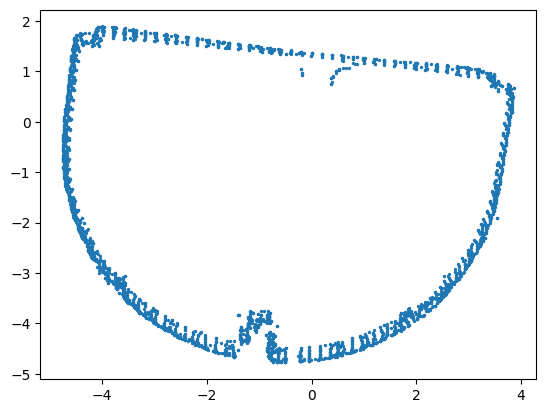

In [106]:
def slice_points2img(slice_points, normal):
    dist = np.sum(slice_points*normal, axis=1)

    dis_2d, dis_3d = (normal[0]**2+normal[1]**2)**(1/2), (normal[0]**2+normal[1]**2+normal[2]**2)**(1/2)
    cos_a, sin_a = 1, 0
    cos_b, sin_b = 1, 0
    cos_r, sin_r = normal[2]/dis_3d, dis_2d/dis_3d
    R_matrix = np.array([[normal[1]/dis_2d,             -normal[0]/dis_2d,              0           ],
                         [(normal[0]*normal[2])/dis_2d, (normal[1]*normal[2])/dis_2d,   -dis_2d     ],
                         [normal[0],                    normal[1],                      normal[2]   ]])

    projected_points = slice_points - np.dot(dist.reshape(len(dist), 1), normal.reshape(1, 3))
    projected_xy_points = np.array([np.dot(R_matrix, projected_points[i])[:2] for i in range(len(projected_points))])
    for i in range(len(projected_xy_points)):
        projected_xy_points[i][1] = -projected_xy_points[i][1]
    return projected_xy_points
projected_xy_points = slice_points2img(pointcloud_as_array, normal)
plt.scatter(projected_xy_points[:, 0], projected_xy_points[:, 1], s = 2)  # 상하 반전

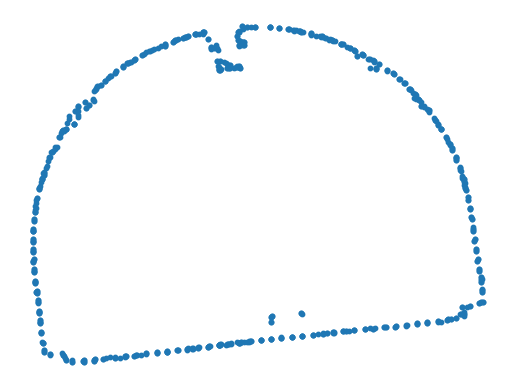

In [107]:
projected_xy_points = slice_points2img(points, normal)
# 상하 반전 적용
projected_xy_points[:, 1] = -projected_xy_points[:, 1]
plt.scatter(projected_xy_points[:, 0], projected_xy_points[:, 1], s = 10)  # 상하 반전
plt.axis('off')
plt.savefig(os.path.join('output_{}.png'.format(int(iterval*100))), bbox_inches='tight', dpi=300)

투영된 2D 다각형의 면적: 44.8205532096718 m^3
DXF 파일이 'convex_hull.dxf'로 저장되었습니다.


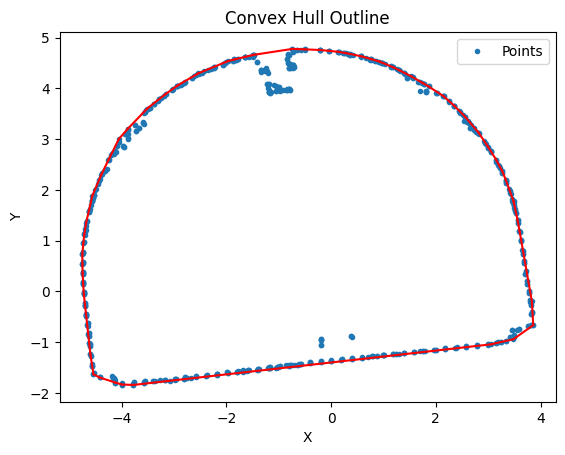

In [108]:
import pandas as df
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Point, LineString, Polygon
y = projected_xy_points[:, 0]  # x 좌표
z = projected_xy_points[:, 1]  # y 좌표

points = np.column_stack((y, z))

# Convex Hull 계산
hull = ConvexHull(points)
hull_vertices = points[hull.vertices]

# 4. Shapely를 이용한 면적 계산
polygon = Polygon(hull_vertices)
area = polygon.area
print(f"투영된 2D 다각형의 면적: {area} m^3")

plt.figure()
plt.plot(points[:, 0], points[:, 1], 'o', label='Points',  markersize=3)

# Convex Hull의 외곽선 그리기
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

# DXF 파일로 저장하기
doc = ezdxf.new(dxfversion='R2010')
msp = doc.modelspace()

# 점들 추가 (원하는 경우)
for point in points:
    msp.add_point(point)

# Convex Hull 외곽선 추가
for simplex in hull.simplices:
    start_point = points[simplex[0]]
    end_point = points[simplex[1]]
    msp.add_line(start=start_point, end=end_point)

# DXF 파일로 저장
doc.saveas("convex_hull.dxf")
print("DXF 파일이 'convex_hull.dxf'로 저장되었습니다.")


plt.title('Convex Hull Outline')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show() 